In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
from scipy import stats

import seaborn as sns
import pylab as plt
from statannot import add_stat_annotation
import statsmodels.api as sm

import missingno as msn

from importlib import reload
from functools import reduce
import glob
import datetime
import re

import sys
sys.path.insert(1,'../scripts')
import utils
import plots

from sklearn import cluster, decomposition,preprocessing,linear_model,model_selection,metrics,neighbors,mixture
from sklearn.pipeline import Pipeline
from tsfresh import feature_selection,select_features

import pickle

# Load Data

In [3]:
data_path = '/scratch/c.c21013066/data/ppmi'
path = '/scratch/c.c21013066/data/ppmi/accelerometer'

demo = pd.read_csv(f'{data_path}/phenotypes2021/demographics_clean.csv',parse_dates=['date_birth'])
behavior = pd.read_csv(f'{data_path}/phenotypes2021/behavior_clean.csv',parse_dates=['date'])
behavior = behavior.set_index('date').sort_index().reset_index()
updrs = behavior.filter(regex='updrs').columns
cognitive = ['semantic_fluency','moca','benton','lns','hvlt_recall','hvlt_recognition','hvlt_retention','symbol_digit']
neuropsychiatric = ['stai_trait','stai_state','gds','quip']
autonome = ['epworth','rbd','systolic_bp_drop','scopa_aut','upsit']
dailyfunctioning = ['se_adl','updrs_i']
motor = ['updrs_ii','updrs_iii_ON','updrs_iii_OFF','updrs_iii_NoMed','updrs_iii_NaN','updrs_iv']

subset = demo['participant'].sample(10)

In [4]:
merged, ambulatory, step, sleep, pulse, pulsevar = utils.load_timeseries(demo,path)
# load extracted features
f = utils.read_extracted_features(f'{path}/extracted_features')
for i,mod in enumerate([ambulatory,step,sleep,pulse,pulsevar]):
    age = mod.groupby('subject')[['age_accelerometry']].agg(['min','max','mean','median'])
    if i == 0:
        ages = age.copy(deep=True)
    else:
        ages = pd.concat([ages,age])
        ages = ages[~ages.index.duplicated(keep='first')]
ages.columns = ['_'.join(col) for col in ages.columns.values]

../scripts/utils.py:77: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['date'] = df['time'].dt.to_period('D')
../scripts/utils.py:77: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['date'] = df['time'].dt.to_period('D')
../scripts/utils.py:77: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['date'] = df['time'].dt.to_period('D')
../scripts/utils.py:85: FutureWarning: ['time_local', 'sleep_onset_time_local', 'sleep_offset_time_local', 'time_day'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  features = df.groupby('subject')[df_raw.columns[5:]].agg(['size','mean','std','max','min'])
../scripts/utils.py:77: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['date'] = df['time'].dt.to_period('D')

In [7]:
m = pd.merge(ages.reset_index(),f,right_on='participant',left_on='subject',how='right')
m = pd.merge(demo,m,on='participant',how='right')
features = f.columns[1:]
covs = np.hstack([ages.columns,'male','education','pd'])
m['male'] = m['gender'].replace(['f','m'],[0,1])
m = pd.merge(m,pd.get_dummies(m.set_index('participant')['diagnosis']),on='participant')

## Get Principal Components for digital timeseries data

In [9]:
PD = m[m['diagnosis']=='pd']

In [10]:
nona = PD.dropna(subset=features) # keep subjects with complete info
X = nona[features].values
X = preprocessing.StandardScaler().fit_transform(X) # normalizing the features
pca_all = decomposition.PCA()
principalComponents = pca_all.fit_transform(X)

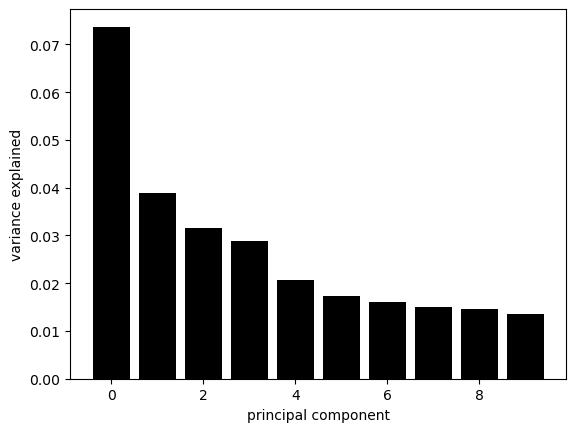

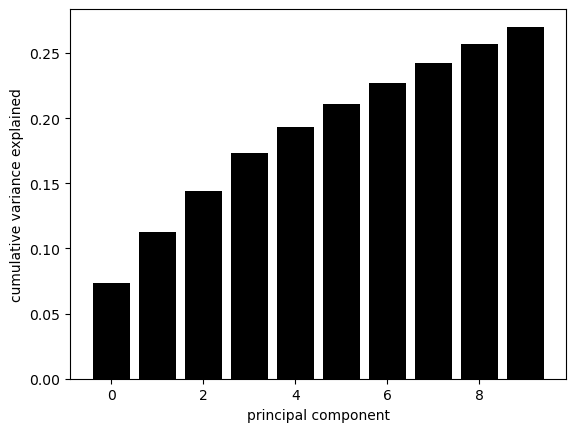

In [11]:
thrsh = 0.9
npcs = np.argwhere(pca.explained_variance_ratio_.cumsum()>thrsh)[0][0]
plt.bar(x=np.arange(10),height=pca.explained_variance_ratio_[:10],color='k')
#plt.axvline(npcs,0,1,ls='--',color='red')
plt.xlabel('principal component')
plt.ylabel('variance explained');
plt.show()
plt.bar(x=np.arange(10),height=pca.explained_variance_ratio_.cumsum()[:10],color='k')
#plt.axvline(npcs,0,1,ls='--',color='red')
plt.xlabel('principal component')
plt.ylabel('cumulative variance explained');

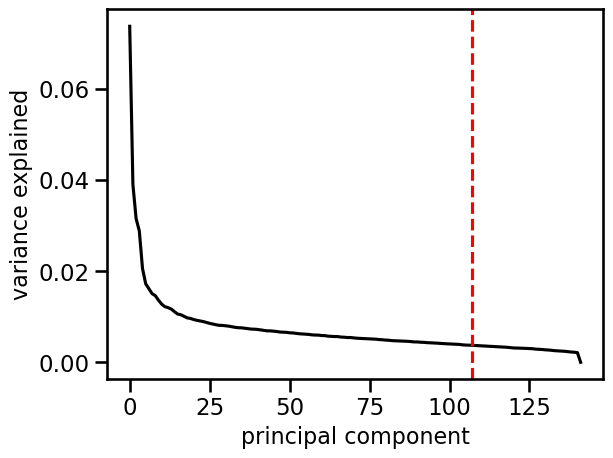

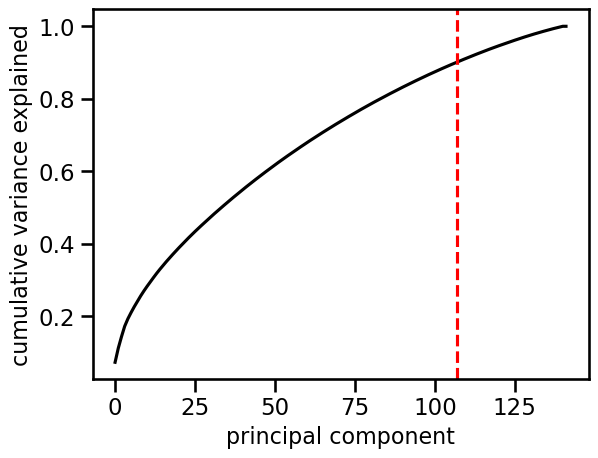

In [64]:
thrsh = 0.9
npcs = np.argwhere(pca_all.explained_variance_ratio_.cumsum()>thrsh)[0][0]
plt.plot(pca_all.explained_variance_ratio_,color='k')
plt.axvline(npcs,0,1,ls='--',color='red')
plt.xlabel('principal component')
plt.ylabel('variance explained');
plt.show()
plot_context()
plt.plot(pca_all.explained_variance_ratio_.cumsum(),color='k')
plt.axvline(npcs,0,1,ls='--',color='red')
plt.xlabel('principal component')
plt.ylabel('cumulative variance explained');
plt.savefig('/scratch/c.c21013066/images/ppmi/studywatch/PCA_PD.png',bbox_inches='tight',dpi=300);
plt.savefig('/scratch/c.c21013066/images/ppmi/studywatch/PCA_PD.pdf',bbox_inches='tight',dpi=300);

In [13]:
PC_df = pd.DataFrame(principalComponents,columns=[f'PC_{i}' for i in range(principalComponents.shape[1])])
nona[PC_df.columns] = PC_df.values.copy()

/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
<ipython-input-13-2f801abb8e09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nona[PC_df.columns] = PC_df.values.copy()
/scratch/c.c21013066/docker/envs/py38R/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<AxesSubplot: xlabel='Principal Component - 1', ylabel='Principal Component - 2'>

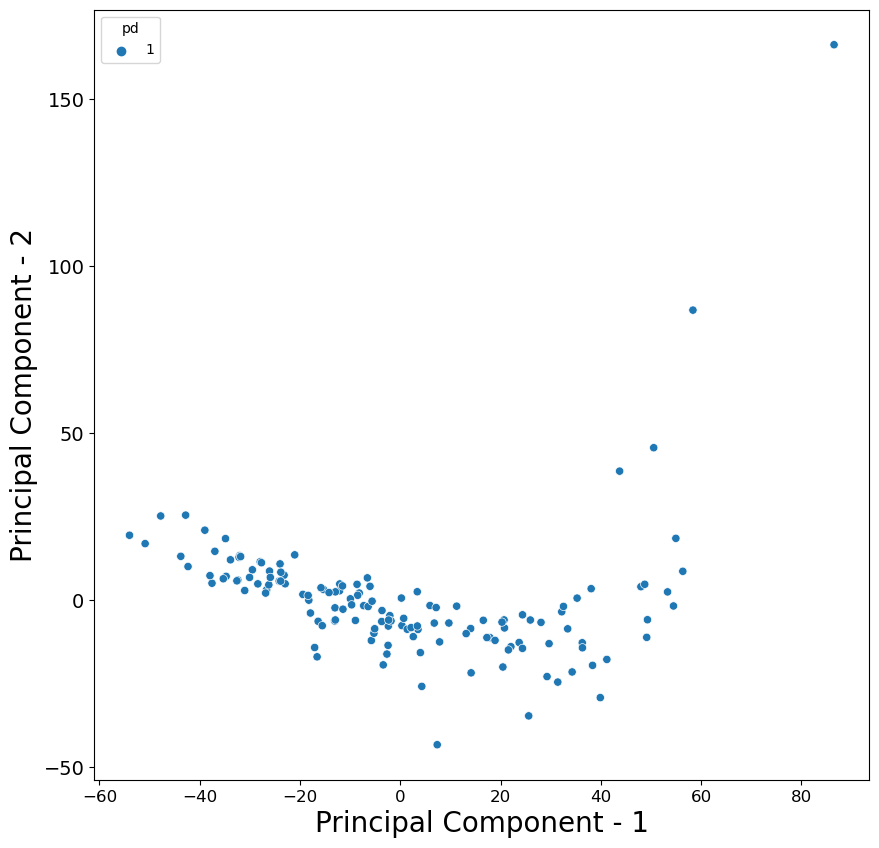

In [14]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
sns.scatterplot(x='PC_0',y='PC_1',hue='pd',data=nona)

## Get Principal Components for clinical scores

In [11]:
# Show random effect distribution
datscan_t =['datscan_mean','datscan_asymmetry','datscan_putamen_mean',
           'datscan_caudate_mean','datscan_caudate_asymmetry','datscan_putamen_asymmetry']
bio_t =['ptau','ttau','abeta','alphasynuclein','gfap','nfl']
ledd_t = ['LEDD']

kind = 'linear'
scale = False
merged = pd.read_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/fixed+randomeffects_notscaled.csv')
# replace biological with scaled version
datasc = pd.read_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/fixed+randomeffects.csv')

if scale:
    merged[[f'{i}_intercept' for i in np.hstack([ledd_t,datscan_t,bio_t])]] = datasc[[f'{i}_intercept' for i in np.hstack([ledd_t,datscan_t,bio_t])]]
    if kind == 'linear':
        merged[[f'{i}_slope' for i in np.hstack([ledd_t,datscan_t,bio_t])]] = datasc[[f'{i}_slope' for i in np.hstack([ledd_t,datscan_t,bio_t])]]
    elif kind == 'squared':
        merged[[f'{i}_slope1' for i in np.hstack([datscan_t,bio_t])]] = datasc[[f'{i}_slope1' for i in np.hstack([datscan_t,bio_t])]]
        merged[[f'{i}_slope2' for i in np.hstack([datscan_t,bio_t])]] = datasc[[f'{i}_slope2' for i in np.hstack([datscan_t,bio_t])]]
    
merged = merged.rename(columns={'Unnamed: 0':'participant'})

# Show random effect distribution
kind = 'linear'
data = pd.read_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/fixed+randomeffects_notscaled_medfiltered.csv')
# replace biological with scaled version
datasc = pd.read_csv(f'/scratch/c.c21013066/data/ppmi/analyses/progression/consensuscohort/{kind}/fixed+randomeffects_medfiltered.csv')

if scale:
    data[[f'{i}_intercept' for i in np.hstack([ledd_t])]] = datasc[[f'{i}_intercept' for i in np.hstack([ledd_t])]]
    if kind == 'linear':
        data[[f'{i}_slope' for i in np.hstack([ledd_t])]] = datasc[[f'{i}_slope' for i in np.hstack([ledd_t])]]
    elif kind == 'squared':
        data[[f'{i}_slope1' for i in np.hstack([ledd_t])]] = datasc[[f'{i}_slope1' for i in np.hstack([ledd_t])]]
        data[[f'{i}_slope2' for i in np.hstack([ledd_t])]] = datasc[[f'{i}_slope2' for i in np.hstack([ledd_t])]]
    
data = data.rename(columns={'Unnamed: 0':'participant'})

merged = pd.merge(merged.set_index('participant'),data.set_index('participant').filter(regex='(_intercept|_slope)'),right_index=True,left_index=True,suffixes=["",'_since_medication'],how='outer')

merged['updrs_iii_ON-OFF_intercept_since_medication'] = merged['updrs_iii_ON_intercept_since_medication'] - merged['updrs_iii_OFF_intercept_since_medication']
merged['updrs_iii_ON-OFF_slope_since_medication'] = merged['updrs_iii_ON_slope_since_medication'] - merged['updrs_iii_OFF_slope_since_medication']
merged.loc[np.logical_or(merged['updrs_iii_ON_intercept_since_medication'].isna(),merged['updrs_iii_OFF_intercept_since_medication'].isna()),'updrs_iii_ON-OFF_intercept_since_medication'] = np.nan
merged.loc[np.logical_or(merged['updrs_iii_ON_slope_since_medication'].isna(),merged['updrs_iii_OFF_slope_since_medication'].isna()),'updrs_iii_ON-OFF_slope_since_medication'] = np.nan

In [12]:
datscan_inter = np.array([
       'datscan_mean_intercept', 'datscan_asymmetry_intercept',
       'datscan_putamen_mean_intercept', 'datscan_caudate_mean_intercept',
       'datscan_caudate_asymmetry_intercept',
       'datscan_putamen_asymmetry_intercept'])
datscan_slope = np.array([
       'datscan_mean_slope', 'datscan_asymmetry_slope',
       'datscan_putamen_mean_slope', 'datscan_caudate_mean_slope',
       'datscan_caudate_asymmetry_slope', 'datscan_putamen_asymmetry_slope'])
SBR_inter = np.array([
       'datscan_mean_intercept',
       'datscan_putamen_mean_intercept', 'datscan_caudate_mean_intercept'])
SBR_slope = np.array([
       'datscan_mean_slope', 
       'datscan_putamen_mean_slope', 'datscan_caudate_mean_slope'])
asym_inter = np.array([
        'datscan_asymmetry_intercept',
       'datscan_caudate_asymmetry_intercept',
       'datscan_putamen_asymmetry_intercept'])
asym_slope = np.array([
        'datscan_asymmetry_slope',
       'datscan_caudate_asymmetry_slope', 'datscan_putamen_asymmetry_slope'])
csf_inter = merged.filter(regex='(ptau|ttau|alpha|abeta|gfap|nfl).*intercept').columns
csf_slope = merged.filter(regex='(ptau|ttau|alpha|abeta|gfap|nfl).*slope').columns
motor_inter = merged.filter(regex='(updrs_ii_|updrs_iii_OFF_).*intercept$').columns
motor_slope = merged.filter(regex='(updrs_ii_|updrs_iii_OFF_).*slope$').columns
cog_inter = merged.filter(regex='(seman|moca|benton|lns|hvlt|symbol).*intercept').columns
cog_slope = merged.filter(regex='(seman|moca|benton|lns|hvlt|symbol).*slope').columns
psy_inter = merged.filter(regex='(gds|stai|quip).*intercept').columns
psy_slope = merged.filter(regex='(gds|stai|quip).*slope').columns
aut_inter = merged.filter(regex='(scopa|systolic|rbd|epworth).*intercept').columns
aut_slope = merged.filter(regex='(scopa|systolic|rbd|epworth).*slope').columns
daily_inter = merged.filter(regex='(updrs_i_|se_ad).*intercept').columns
daily_slope = merged.filter(regex='(updrs_i_|se_ad).*slope').columns
ledd_inter = merged.filter(regex='(LEDD|updrs_iii_ON-OFF|updrs_iv)_intercept_since_medication').columns
ledd_slope = merged.filter(regex='(LEDD|updrs_iii_ON-OFF|updrs_iv)_slope_since_medication').columns

cl_names = np.array(['UPDRS II','UPDRS III OFF','Semantic Fluency', 'MOCA', 'Benton',
       'Letter Number Sequencing', 'HVLT Recall', 'HVLT Recognition', 'HVLT Retention',
       'Symbol Digit', 'STAI trait', 'STAI state', 'GDS', 'QUIP',
       'Epworth Sleepiness', 'RBDSQ', 'Systolic BP Drop', 'SCOPA autonome',
       'UPDRS I','Schwab England ADL','SBR mean','SBR asymmetry','putamen mean',
           'caudate mean','caudate asymmetry','putamen asymmetry','ptau','ttau','abeta','alphasynuclein','gfap','nfl','UPDRS IV','LEDD','UPRDS III ON - OFF'])
med_names = np.array(['UPDRS IV','LEDD','UPRDS III ON - OFF',])


names_inter = np.hstack([motor_inter,cog_inter,psy_inter,aut_inter,daily_inter,datscan_inter,csf_inter,ledd_inter])
names_slope = np.hstack([motor_slope,cog_slope,psy_slope,aut_slope,daily_slope,datscan_slope,csf_slope,ledd_slope])    

inter_labels = pd.Series(np.hstack([np.repeat('motor',len(motor_inter)),np.repeat('cognition',len(cog_inter)),
                              np.repeat('neuropsychiatric',len(psy_inter)),np.repeat('autonome',len(aut_inter)),
                             np.repeat('daily',len(daily_inter)),
                                    np.repeat('DaTscan',len(datscan_inter)),np.repeat('CSF',len(csf_inter)),np.repeat('medication',len(ledd_inter))]),index=cl_names)

slope_labels = pd.Series(np.hstack([np.repeat('motor',len(motor_slope)),np.repeat('cognition',len(cog_slope)),
                              np.repeat('neuropsychiatric',len(psy_slope)),np.repeat('autonome',len(aut_slope)),
                             np.repeat('daily',len(daily_slope)),
                                    np.repeat('DaTscan',len(datscan_slope)),np.repeat('CSF',len(csf_slope)),np.repeat('medication',len(ledd_slope))]),index=cl_names)
med_inter_labels = pd.Series(np.repeat('medication',len(ledd_inter)),index=med_names)
med_slope_labels = pd.Series(np.repeat('medication',len(ledd_slope)),index=med_names)

In [34]:
#modality_slopes PCA

def plot_PCA(pca):
    plots.plot_context()
    plt.plot(pca.explained_variance_ratio_.cumsum(),color='k')
    plt.xlabel('principal component')
    plt.ylabel('cumulative variance explained');
    plt.show()
    
def get_PCA(df,features,name,first=True):
    print(features)
    nona = df.dropna(subset=features) # keep subjects with complete info
    X = nona[features].values
    X = preprocessing.StandardScaler().fit_transform(X) # normalizing the features
    pca = decomposition.PCA()
    principalComponents = pca.fit_transform(X)
    #plot_PCA(pca)
    print(name,pca.explained_variance_ratio_)
    if first:
        df.loc[nona.index,f'{name}_PC'] = principalComponents[:,0]
    else:
        cols = [f'{name}_PC_{i}' for i in range(principalComponents.shape[1])]
        df.loc[nona.index,cols] = principalComponents
    return pca,df,pca.explained_variance_ratio_[0],

def get_kind(ls,kind='intercept'):
    return [i for i in ls if re.search(kind,i)]

def get_loadings(pca):
    return pca.components_.T * np.sqrt(pca.explained_variance_)

def plot_loadings(loadings_df,var_exp):
    plots.plot_context()
    fig = plt.figure(figsize=(5,7))
    ax = sns.barplot(data=loadings_df,y=loadings_df.index,x=0,color='k')
    ax.set_xlabel('PC 0')
    ax.set_title(f"explained variance ratio {var_exp:.2f}")
    plt.show()

mot = ['updrs_ii_intercept', 'updrs_ii_slope', 'updrs_iii_ON_intercept',
       'updrs_iii_ON_slope', 'updrs_iii_OFF_intercept', 'updrs_iii_OFF_slope',
       'updrs_iv_intercept', 'updrs_iv_slope']
cogn = ['hvlt_recall_intercept',
       'hvlt_recall_slope', 'hvlt_recognition_intercept',
       'hvlt_recognition_slope', 'hvlt_retention_intercept',
       'hvlt_retention_slope', 'symbol_digit_intercept', 'symbol_digit_slope','benton_intercept', 'benton_slope','semantic_fluency_intercept',
       'semantic_fluency_slope','lns_intercept', 'lns_slope',
       'moca_intercept', 'moca_slope']
# bio_PD = [
       
    
#        'datscan_mean_intercept', 'datscan_mean_slope',
#        'datscan_asymmetry_intercept', 'datscan_asymmetry_slope',
#        'datscan_putamen_mean_intercept', 'datscan_putamen_mean_slope',
#        'datscan_caudate_mean_intercept', 'datscan_caudate_mean_slope',
#        'datscan_caudate_asymmetry_intercept',
#        'datscan_caudate_asymmetry_slope',
#        'datscan_putamen_asymmetry_intercept',
#        'datscan_putamen_asymmetry_slope']
# bio_AD = ['ptau_intercept', 'ptau_slope',
#        'ttau_intercept', 'ttau_slope', 'abeta_intercept',
#        'abeta_slope']
aut = ['epworth_intercept','epworth_slope','scopa_aut_intercept', 'scopa_aut_slope','rbd_intercept', 'rbd_slope','systolic_bp_drop_intercept',
       'systolic_bp_drop_slope']
daily = ['se_adl_intercept', 'se_adl_slope','updrs_i_intercept', 'updrs_i_slope',
       'updrs_ii_intercept']
psychiatric = ['quip_intercept', 'quip_slope','gds_intercept', 'gds_slope','stai_trait_intercept',
       'stai_trait_slope', 'stai_state_intercept', 'stai_state_slope']
# alpha = ['alphasynuclein_intercept',
#     'alphasynuclein_slope']
# ttau = ['ttau_intercept', 'ttau_slope']
# ptau = ['ptau_intercept', 'ptau_slope']
# abeta = ['abeta_intercept',
#     'abeta_slope']
# gfap = ['gfap_intercept','gfap_slope']
# nfl = ['nfl_intercept','nfl_slope']
ledd = ['LEDD_intercept','LEDD_slope','UPDRS_III_ON_slope']

cognitive
['semantic_fluency_intercept', 'moca_intercept', 'benton_intercept', 'lns_intercept', 'hvlt_recall_intercept', 'hvlt_recognition_intercept', 'hvlt_retention_intercept', 'symbol_digit_intercept']
cognitive_intercept [0.43773421 0.1270586  0.1091903  0.08370855 0.07973806 0.0609636
 0.06038799 0.04121869]


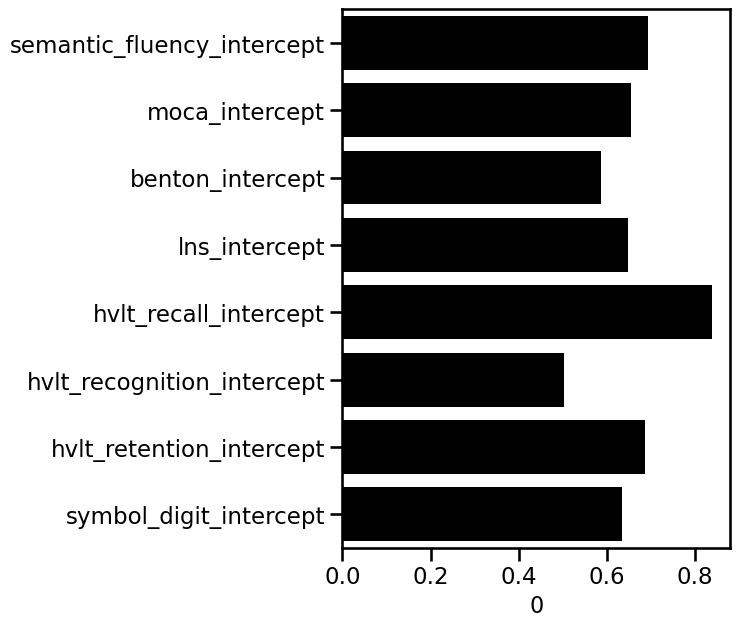

motor
['updrs_ii_intercept', 'updrs_iii_OFF_intercept']
motor_intercept [0.70722151 0.29277849]


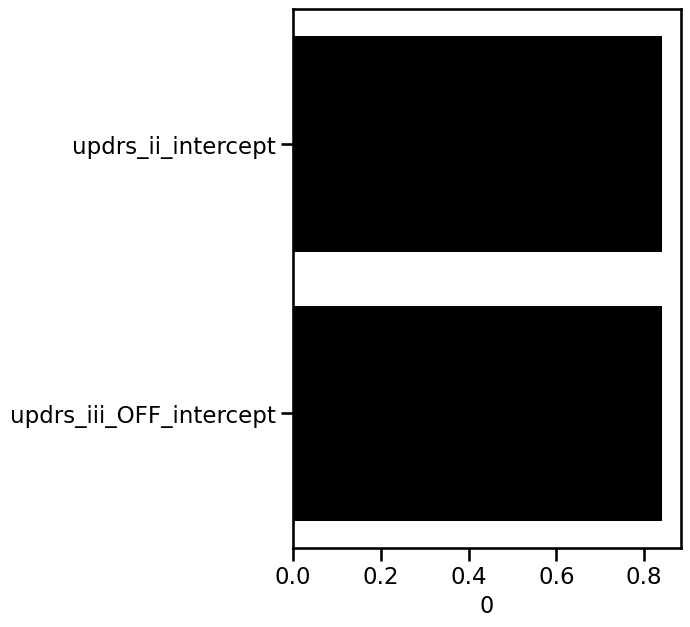

SBR
['datscan_mean_intercept', 'datscan_putamen_mean_intercept', 'datscan_caudate_mean_intercept']
SBR_intercept [9.24911062e-01 7.50400945e-02 4.88437428e-05]


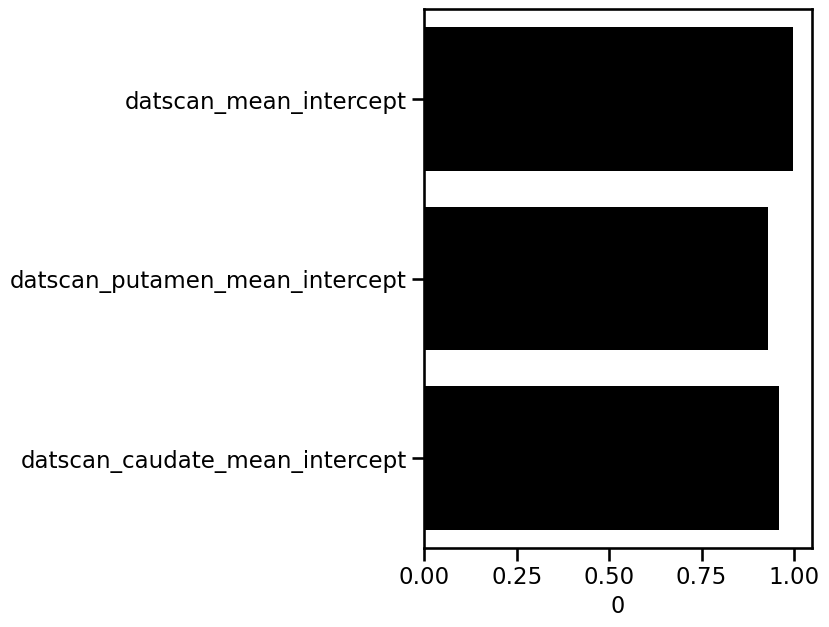

asymmetry
['datscan_asymmetry_intercept', 'datscan_caudate_asymmetry_intercept', 'datscan_putamen_asymmetry_intercept']
asymmetry_intercept [0.77451398 0.2012884  0.02419761]


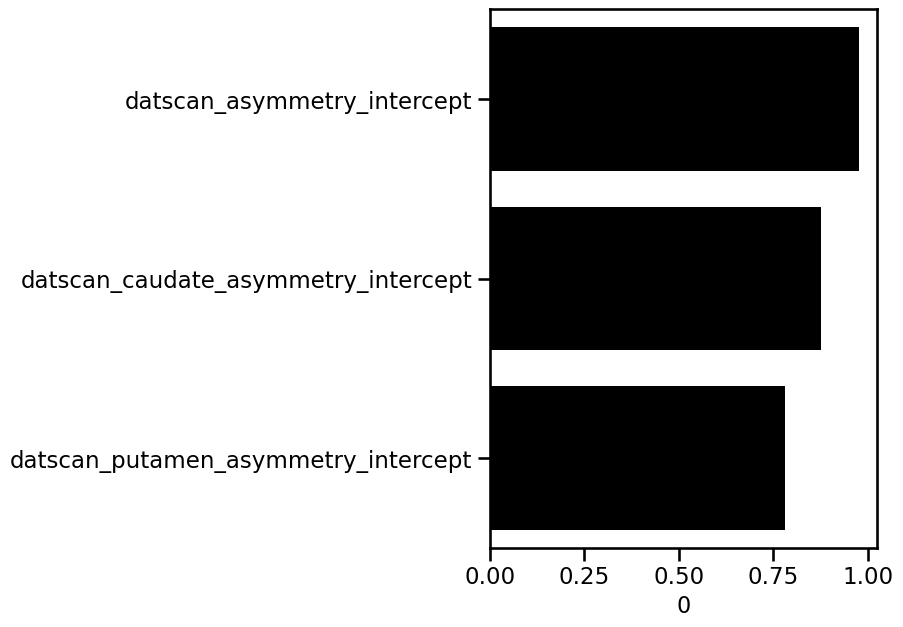

ptau
['ptau_intercept']
ptau_intercept [1.]


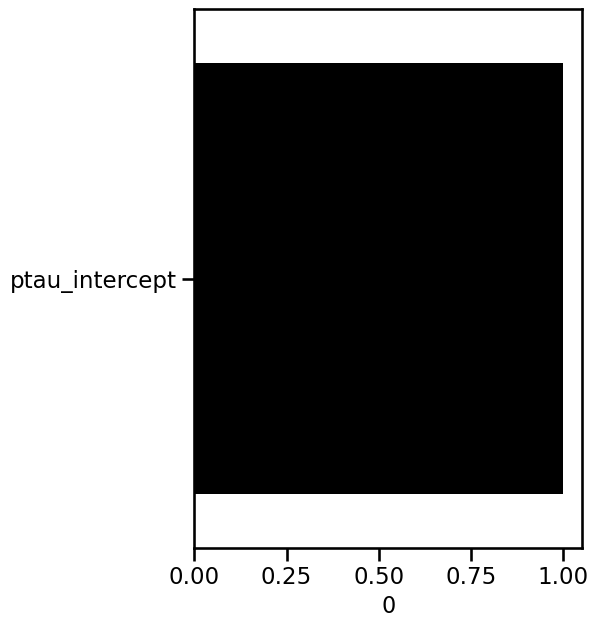

ttau
['ttau_intercept']
ttau_intercept [1.]


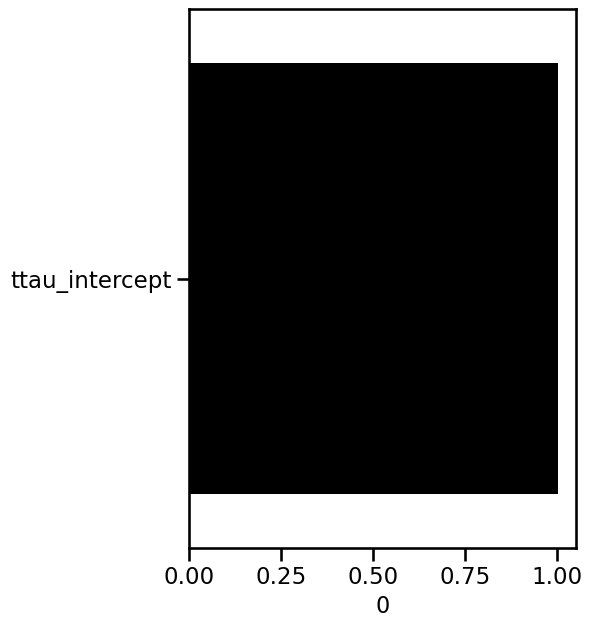

abeta
['abeta_intercept']
abeta_intercept [1.]


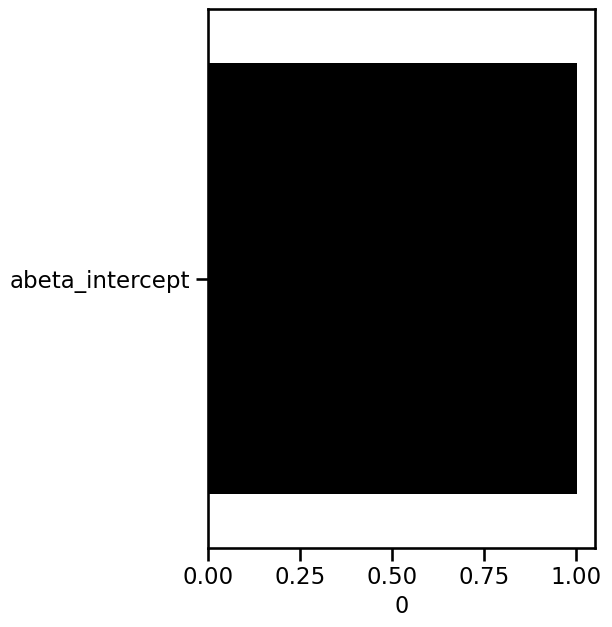

autonome
['epworth_intercept', 'rbd_intercept', 'systolic_bp_drop_intercept', 'scopa_aut_intercept']
autonome_intercept [0.44905251 0.25423718 0.15731153 0.13939878]


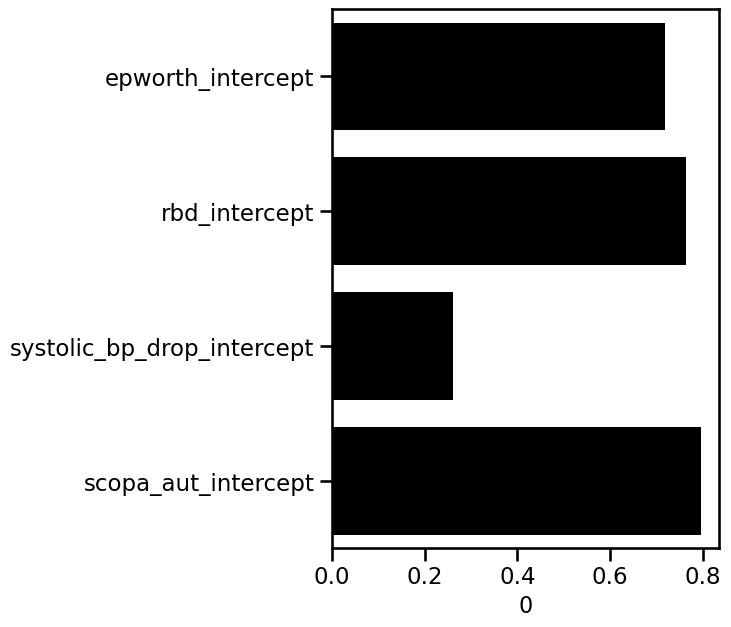

daily
['updrs_i_intercept', 'se_adl_intercept']
daily_intercept [0.64871687 0.35128313]


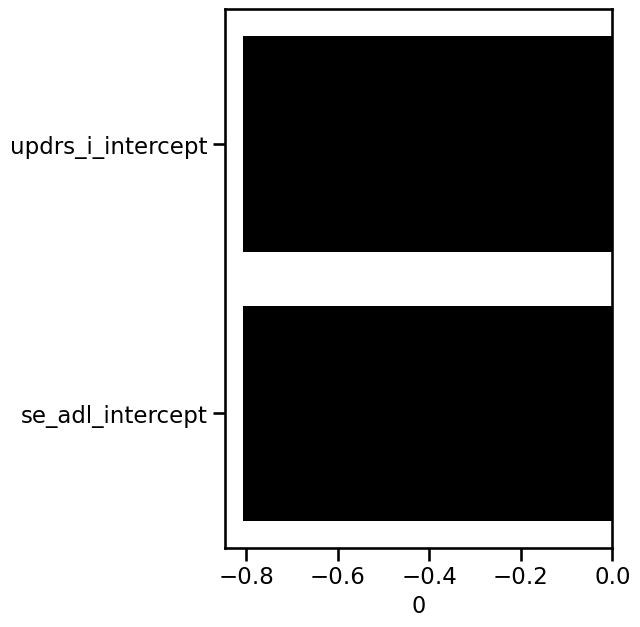

neuropsychiatric
['stai_trait_intercept', 'stai_state_intercept', 'gds_intercept', 'quip_intercept']
neuropsychiatric_intercept [0.65553024 0.22211626 0.08462191 0.03773159]


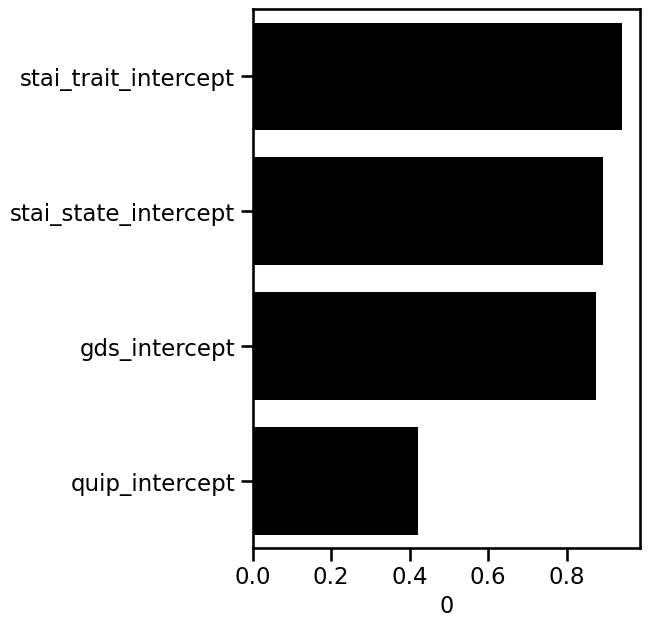

alphasyn
['alphasynuclein_intercept']
alphasyn_intercept [1.]


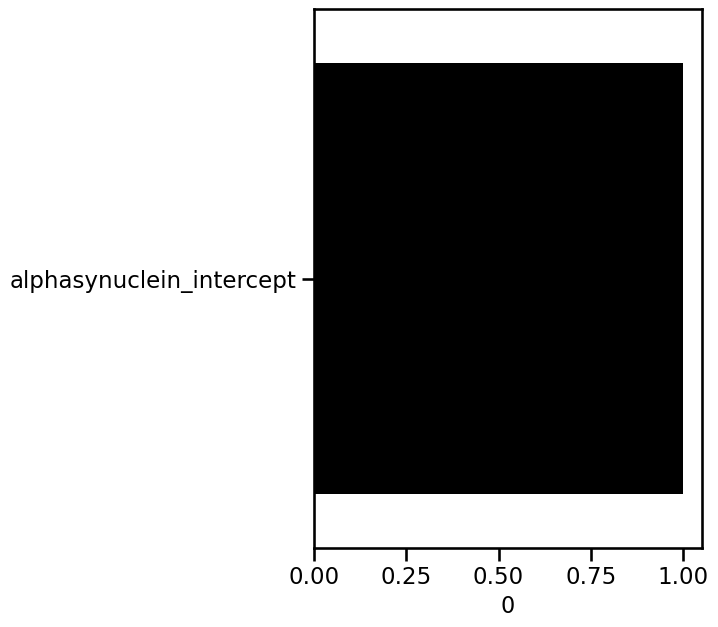

medication
['updrs_iv_intercept_since_medication', 'LEDD_intercept_since_medication', 'updrs_iii_ON-OFF_intercept_since_medication']
medication_intercept [0.40887112 0.32498028 0.26614859]


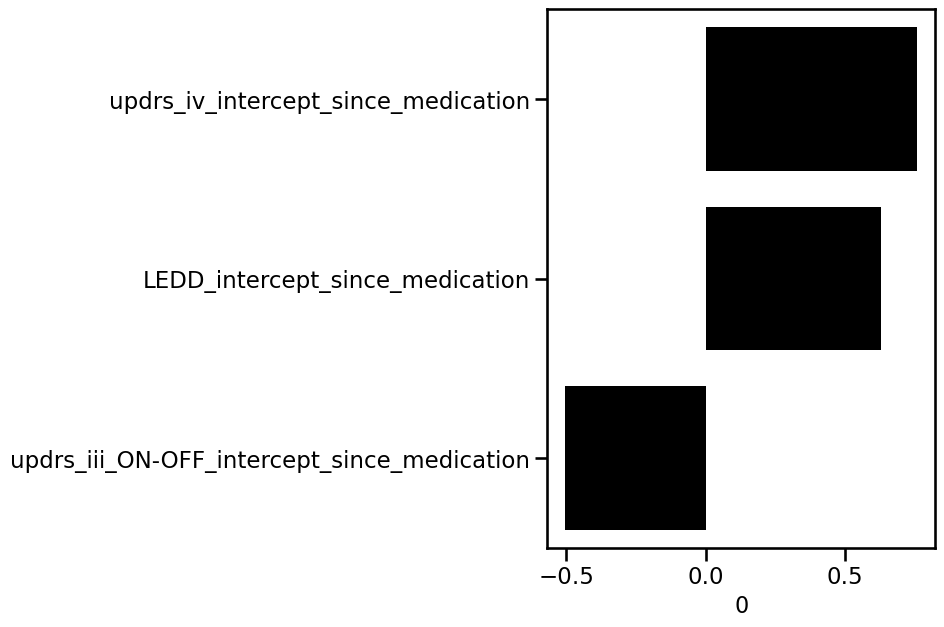

gfap
['gfap_intercept']
gfap_intercept [1.]


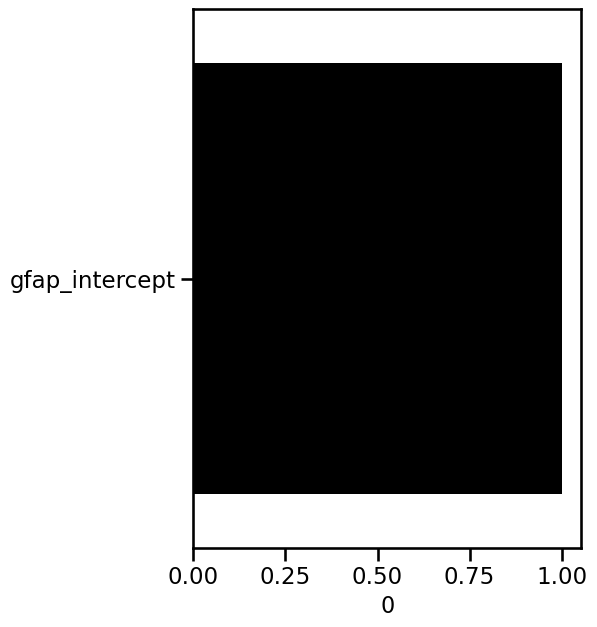

nfl
['nfl_intercept']
nfl_intercept [1.]


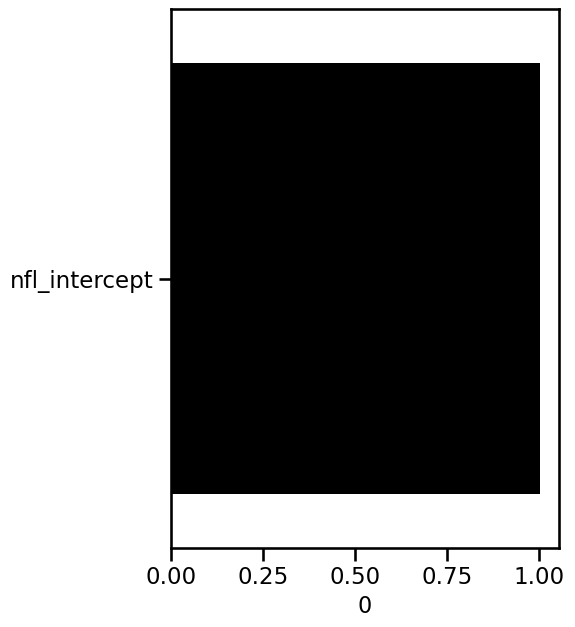

cognitive
['semantic_fluency_slope', 'moca_slope', 'benton_slope', 'lns_slope', 'hvlt_recall_slope', 'hvlt_recognition_slope', 'hvlt_retention_slope', 'symbol_digit_slope']
cognitive_slope [0.5232505  0.10641247 0.1020236  0.07518624 0.07189182 0.04445112
 0.04174716 0.03503708]


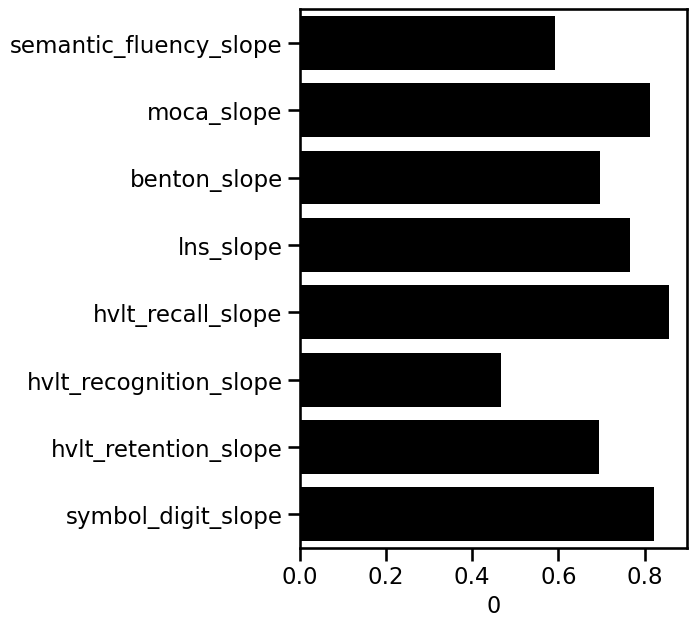

motor
['updrs_ii_slope', 'updrs_iii_OFF_slope']
motor_slope [0.74719746 0.25280254]


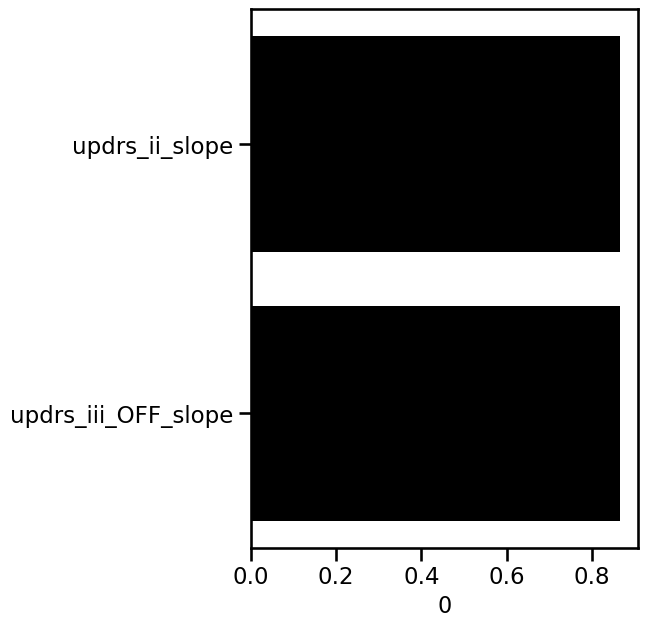

SBR
['datscan_mean_slope', 'datscan_putamen_mean_slope', 'datscan_caudate_mean_slope']
SBR_slope [8.36918756e-01 1.62318629e-01 7.62615072e-04]


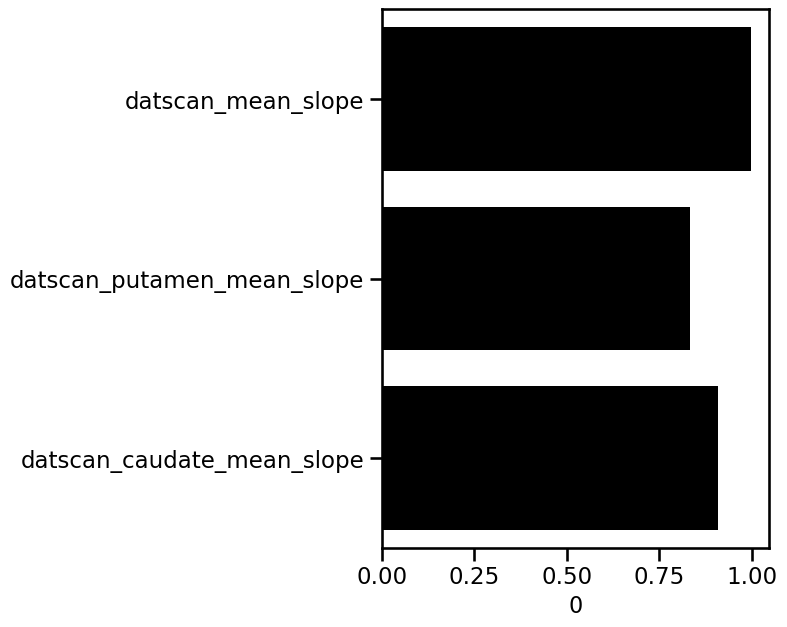

asymmetry
['datscan_asymmetry_slope', 'datscan_caudate_asymmetry_slope', 'datscan_putamen_asymmetry_slope']
asymmetry_slope [0.53458812 0.32509662 0.14031526]


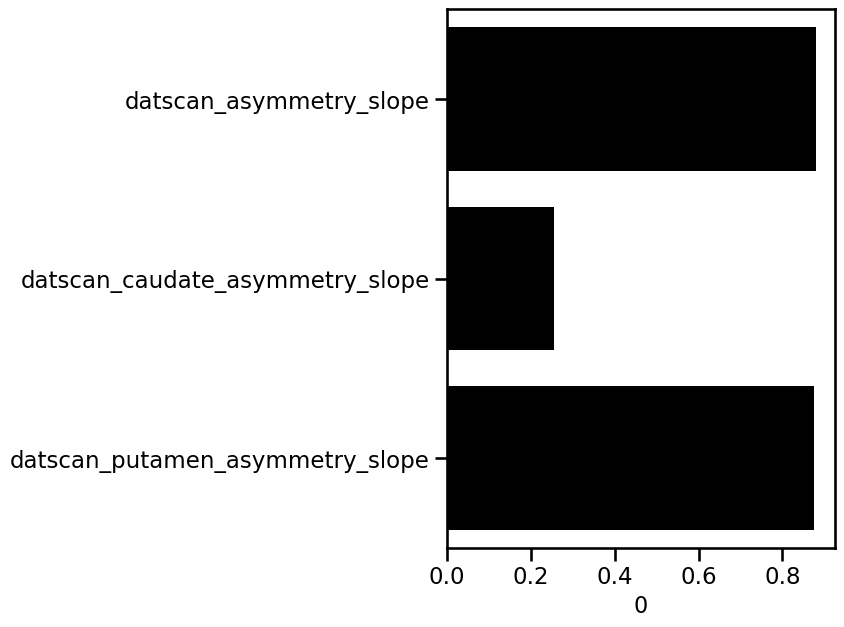

ptau
['ptau_slope']
ptau_slope [1.]


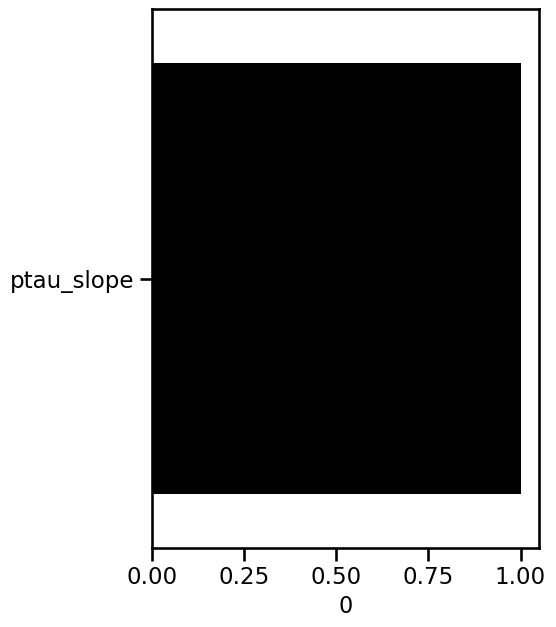

ttau
['ttau_slope']
ttau_slope [1.]


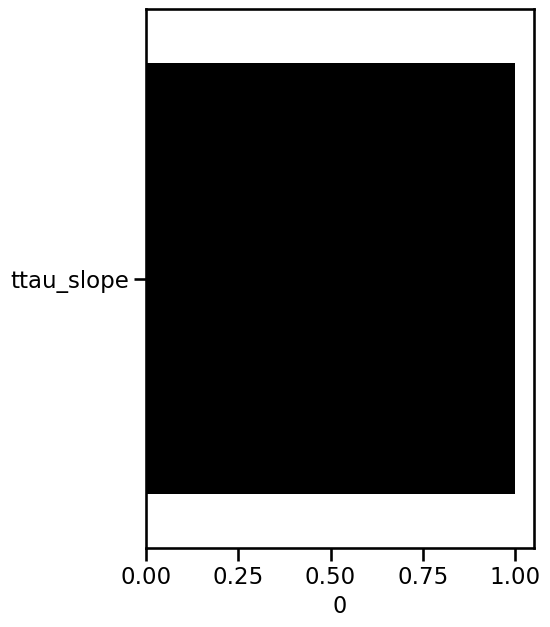

abeta
['abeta_slope']
abeta_slope [1.]


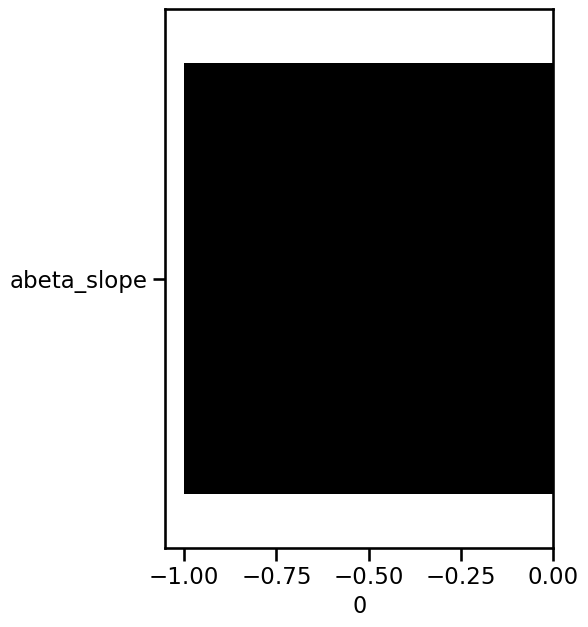

autonome
['epworth_slope', 'rbd_slope', 'systolic_bp_drop_slope', 'scopa_aut_slope']
autonome_slope [0.43500965 0.21999962 0.19858146 0.14640927]


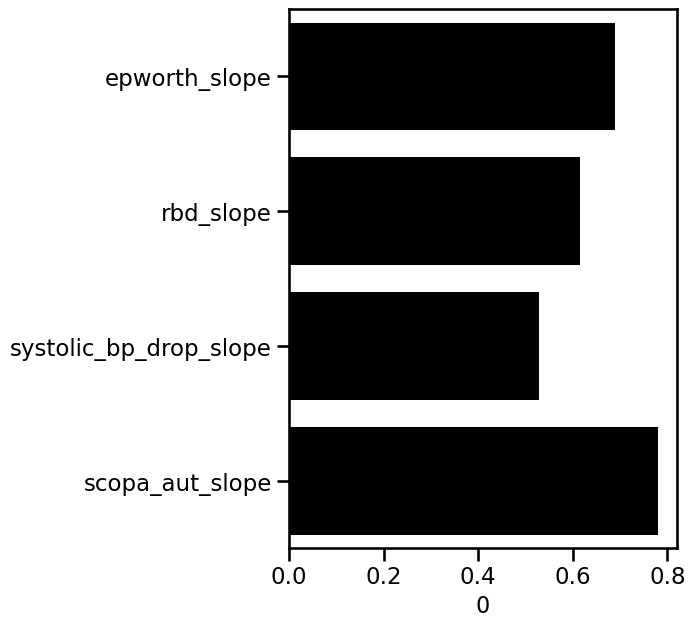

daily
['updrs_i_slope', 'se_adl_slope']
daily_slope [0.76125556 0.23874444]


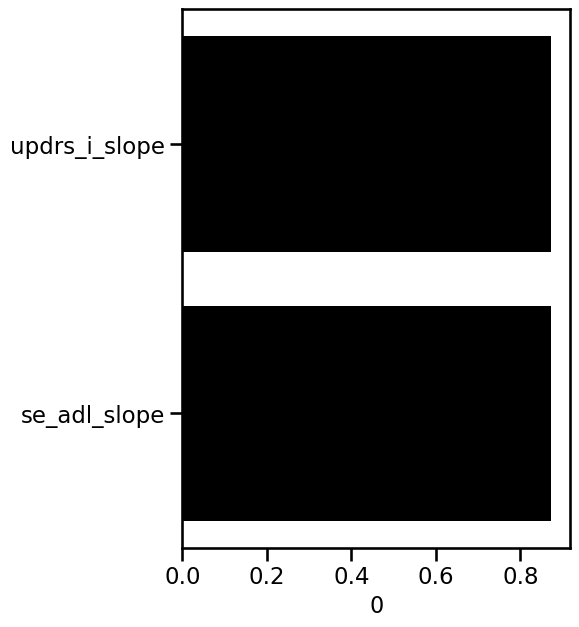

neuropsychiatric
['stai_trait_slope', 'stai_state_slope', 'gds_slope', 'quip_slope']
neuropsychiatric_slope [0.65750469 0.22685597 0.08126384 0.0343755 ]


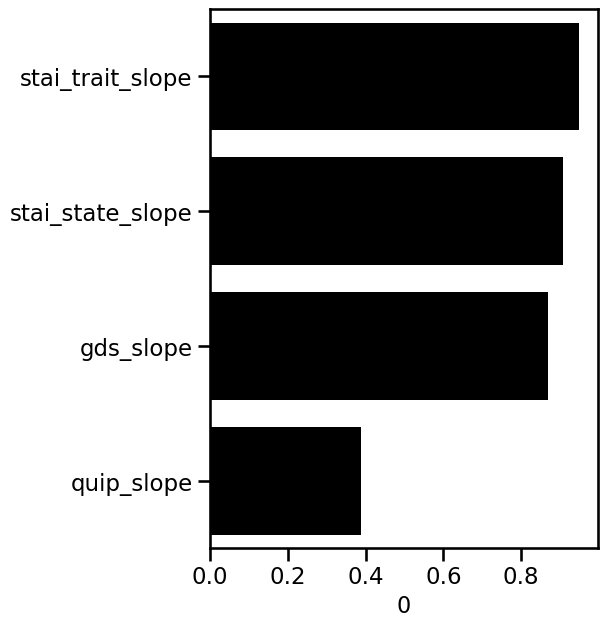

alphasyn
['alphasynuclein_slope']
alphasyn_slope [1.]


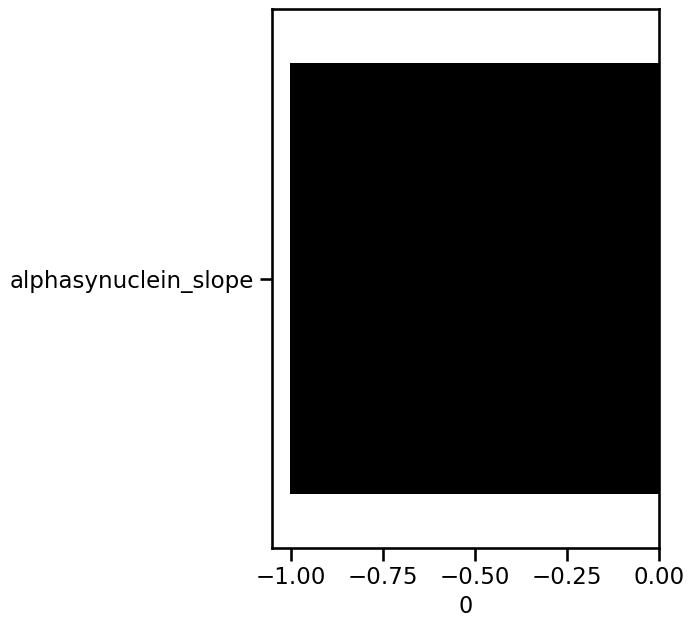

medication
['updrs_iv_slope_since_medication', 'LEDD_slope_since_medication', 'updrs_iii_ON-OFF_slope_since_medication']
medication_slope [0.40904807 0.31822587 0.27272606]


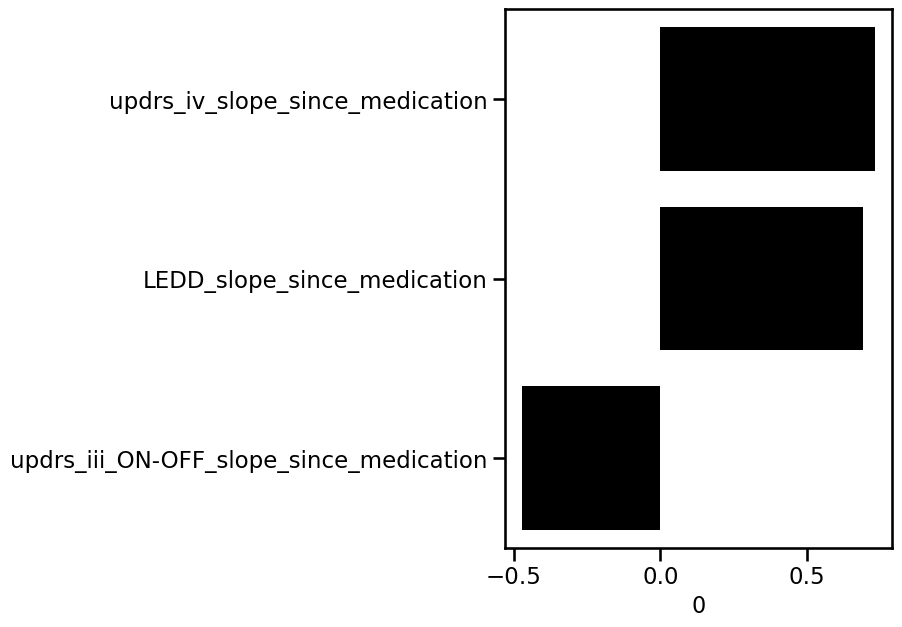

gfap
['gfap_slope']
gfap_slope [1.]


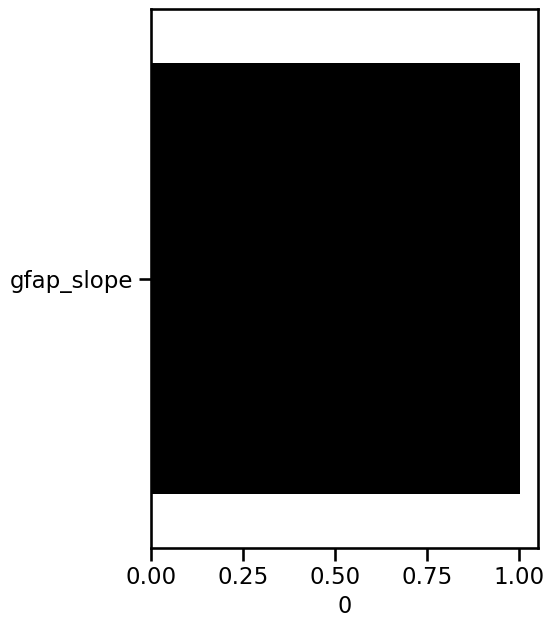

nfl
['nfl_slope']
nfl_slope [1.]


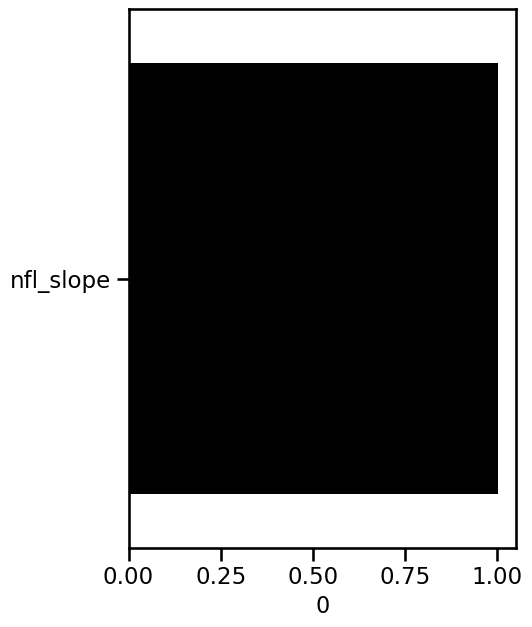

In [33]:
var_exp = pd.DataFrame(columns=['explained_var_0'],index=pd.MultiIndex.from_product([['cognitive','motor','SBR','asymmetry','ptau','ttau','abeta','autonome','daily',
                                                                                      'neuropsychiatric','alphasyn','medication','gfap','nfl'],
                                                                                     ['intercept','slope']],names=['outcome','kind']))
for kind in ['intercept','slope']:
    for mod,cols in zip(['cognitive','motor','SBR','asymmetry','ptau','ttau','abeta','autonome','daily','neuropsychiatric','alphasyn','medication','gfap','nfl'],
                        [np.hstack([cog_inter,cog_slope]),np.hstack([motor_inter,motor_slope]),np.hstack([SBR_inter,SBR_slope]),np.hstack([asym_inter,asym_slope]),
                         ptau,ttau,abeta,np.hstack([aut_inter,aut_slope]),
                         np.hstack([daily_inter,daily_slope]),np.hstack([psy_inter,psy_slope]),alpha,np.hstack([ledd_inter,ledd_slope]),gfap,nfl]):
        print(mod)
        pca,merged,var_exp_ratio = get_PCA(merged,get_kind(cols,kind),f'{mod}_{kind}',first=True)
        loadings = get_loadings(pca)
        loadings_df = pd.DataFrame(loadings,index=get_kind(cols,kind),columns=np.arange(len(get_kind(cols,kind))))
        plot_loadings(loadings_df,var_exp_ratio)
        var_exp.loc[(mod,kind),'explained_var_0'] = var_exp_ratio

# Combine digital and clinical PCs

In [20]:
ratesPC = pd.merge(merged.reset_index(),nona.filter(regex='^PC|_PC_').reset_index(),on='participant',how='outer')
ratesPC.to_csv('/scratch/c.c21013066/data/ppmi/analyses/cluster/PC_clinicalbioleddmedasym_digital.csv')